#  LU3MA201 : Projet / Travail d’étude et de recherche

<!-- dom:AUTHOR: Aya Bouzidi at [Sorbonne Université](http://www.sorbonne-universite.fr/), -->
<!-- Author: -->  
**Aya Bouzidi** ( L3 de Mathématiques à [Sorbonne Université](http://www.sorbonne-universite.fr/) ).

Licence <a href="https://creativecommons.org/licenses/by-nc-nd/4.0/">CC BY-NC-ND</a>

# 3 Distance tangente comme algorithme de classification de chiffres manuscrits

<div id="ch:method_3"></div>

Bien que la méthode de la **SVD** nous donne une bonne précision de classification, elle classifie mal des chiffres bien écrits mais avec un degré de déviation. Voici un exemple : 


<figure>
    <center><img src="chiffre 6 mal reconnu.png" style="width:25%;max-width:800px;"></center>
    <center><figcaption>Chiffre mal reconnu par la SVD</figcaption></center>
</figure>


Notre troisième algorithme basé sur la **méthode tangente** nous permet de bien classifier ce type de chiffres en prenant en compte la déviation du vecteur image. 

Soit $v \in \mathbb{R}^{784}$ et $s(v,\alpha)$ une transformation de $v$ dans le plan de paramètre $\alpha$. ( $s(v,0)=v$ )

**Définition de distance tangente**

La distance tangente est définie comme la distance minimale entre deux courbes. Dans notre problème, il s'agit de la distance minimale entre deux images $p$ et $e$ qu'on peut approcher par $min_{\alpha_p,\alpha_e}||s(p,\alpha_p)-s(e,\alpha_e)||_2^2$.

Par le **théorème de Taylor**, on a:

$s(v,\alpha) \approx s(v,0)+\frac{ds}{d\alpha}(v,0)\alpha$ 

Donc $s(v,\alpha) \approx v + t_v\alpha$ avec $t_v=\frac{ds}{d\alpha}(v,0)$

Si $\alpha=(\alpha_{i})_i$ alors $s(v,\alpha) \approx v + \Sigma _i \frac{\partial s}{\partial \alpha_{i}}(v,0)\alpha_{i} \approx v + T_v\alpha_v^t$ avec $T_v=(\frac{\partial s}{\partial \alpha_{i}}(v,0))_i$ appelée **matrice tangente**

D'où $min_{\alpha_p,\alpha_e}||s(p,\alpha_p)-s(e,\alpha_e)||_2^2=min_{\alpha_p,\alpha_e}||(p-e)+(T_p\alpha_p^t-T_e\alpha_e^t)||_2^2=min_{\alpha_p,\alpha_e}||(p-e)-(-T_p \; T_e)(\alpha_p^t \; \alpha_e^t)^t)||_2^2$

On pose $A=(-T_p \; T_e)$ , $b=p-e$ et $\lambda=(\alpha_p^t \; \alpha_e^t)^t$

Alors $min_{\alpha_p,\alpha_e}||s(p,\alpha_p)-s(e,\alpha_e)||_2^2=min_{\lambda}||b-A\lambda||_2^2$

Qui est un **problème de moindre carré** ! 

On veut écrire chaque image comme une fonction à deux variables: 

Chaque image $p$ peut s'écrire comme une matrice $P$ de taille 28x28. 

On cherche alors $p$ différentiable telle que $p(i,j)=P_{i,j}$ pour tout $(i,j) \in [1,28]$ .($P_{i,j}$ correspond alors à la valeur d'un pixel)

Cela est vérifié pour la fonction discontinue suivante: $p_*(x,y)=\Sigma_{i,j}P_{i,j}\delta(x-i)\delta(y-j)$

Pour avoir la continuité, on convolutionne $p_*$ avec la fonction gaussienne et on obtient $p(x,y)=\Sigma_{i,j}P_{i,j}g_{\sigma}(x-i,y-j)$. (Nous travaillons avec $\sigma=0.9$ pour notre algorithme)

<div id="ch:method_1"></div>

**Exemples de transformations importantes et leurs dérivées**

* **Translation d'axe (Ox)**: $T_X=\frac{\partial p}{\partial x}=p_x$

* **Translation d'axe (Oy)**: $T_Y=\frac{\partial p}{\partial y}=p_y$

* **Rotation de centre l'origine**: $T_X=y\frac{\partial p}{\partial x}-x\frac{\partial p}{\partial y}=yp_x-xp_y$

* **Scaling**: $T_X=x\frac{\partial p}{\partial x}+y\frac{\partial p}{\partial y}=xp_x+yp_y$

* **Transformation parallèle hyperbolique**: $T_X=x\frac{\partial p}{\partial x}-y\frac{\partial p}{\partial y}=xp_x-yp_y$

* **Transformation diagonale hyperbolique**: $T_X=y\frac{\partial p}{\partial x}+x\frac{\partial p}{\partial y}=yp_x+xp_y$

* **Thickening**: $T_X=(\frac{\partial p}{\partial x})^2+(\frac{\partial p}{\partial y})^2=(p_x)^2+(p_y)^2$

<div id="ch:method_1"></div>

Pour différentes transformations importantes du plan, notre algorithme est le suivant: 
    
* **Etape 1:** Pour chaque image de la base d'apprentissage et de la base de tests, calculer sa matrice tangente en fonction de la transformation choisie.


* **Etape 2:** Pour chaque image de la base de tests, calculer la distance tangente par rapport à toutes les images de la base d'apprentissage et la classifier selon le chiffre correspondant à l'image qui donne la plus petite distance tangente.

<div id="ch:method_1"></div>

**Les instructions suivantes permettent de charger les données de chiffres manuscrits disponibles dans les fichiers base_apprentissage.mat et base_test.mat :**

In [241]:
import scipy.io as spi
import numpy as np
import matplotlib.pyplot as plt

mat=spi.loadmat("base_apprentissage.mat")
data_train=np.transpose(mat['data'])
label_train=np.array(mat['label'])[0] #label: chiffre numérisé
label_train=label_train.astype(int) #Les labels sont stockés en flottants, on les convertit en entiers

mat = spi.loadmat("base_test.mat")
data_test = np.transpose(mat['data'])
label_test = np.array(mat['label'])[0]
label_test =label_test.astype(int)

In [242]:
tuples=[]
for i in range(28):
    for j in range(28):
        tuples+=[(i,j)]
        
tuples_x=np.array([tuples[i][0] for i in range(784)])
tuples_y=np.array([tuples[i][1] for i in range(784)])

<div id="ch:method_1"></div>

**On lisse les images:**

In [243]:
def smooth(v):
    P=np.reshape(v,(28,28))
    def p(x,y):
        S=[P[i,j]*np.e**(-((x-i)**2+(y-j)**2)/(2*0.9**2)) for i,j in tuples]
        return sum(S)
    return p(tuples_x,tuples_y)

In [244]:
smooth_train=[smooth(data_train[i]) for i in range(800)]
smooth_test=[smooth(data_test[i]) for i in range(200)]

<div id="ch:method_1"></div>

**Voici l'image d'un chiffre:**

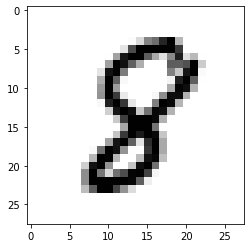

In [245]:
plt.imshow(np.reshape(data_train[0],(28,28)), cmap='gray_r')

<div id="ch:method_1"></div>

**Voici sa version lissée:**

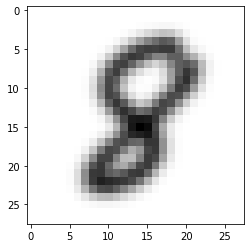

In [246]:
plt.imshow(np.reshape(smooth_train[0],(28,28)), cmap='gray_r')

<div id="ch:method_1"></div>

**On calcule les p_x pour les chiffres:**

In [247]:
def T_X(v):
    P=np.reshape(v,(28,28))
    P_=np.gradient(P)[0]
    return np.reshape(P_,(1,-1))[0]

In [248]:
p_x_train=[T_X(smooth_train[i]) for i in range(800)]
p_x_test=[T_X(smooth_test[i]) for i in range(200)]

<div id="ch:method_1"></div>

**Voici p_x pour le chiffre vu précedemment:**

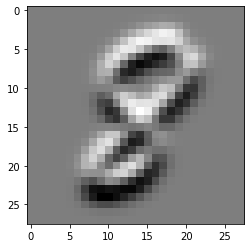

In [249]:
plt.imshow(-np.reshape(p_x_train[0],(28,28)), cmap='gray_r')

<div id="ch:method_1"></div>

**On calcule les p_y pour les chiffres:**

In [253]:
def T_Y(v):
    P=np.reshape(v,(28,28))
    P_=np.gradient(P)[1]
    return np.reshape(P_,(1,-1))[0]

In [254]:
p_y_train=[T_Y(smooth_train[i]) for i in range(800)]
p_y_test=[T_Y(smooth_test[i]) for i in range(200)]

<div id="ch:method_1"></div>

**Voici p_y pour le chiffre vu précedemment:**

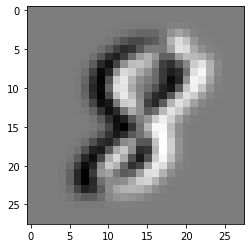

In [255]:
plt.imshow(np.reshape(p_y_train[0],(28,28)), cmap='gray_r')

## 3.1 Translation d'axe (Ox) 

<div id="ch:method_1"></div>

**Fonction de classification pour la X-translation:**

In [259]:
def estim_X(j): #estime l'image data_test[j]
    A=[np.hstack((np.reshape(-p_x_train[i],(-1,1)),np.reshape(p_x_test[j],(-1,1)))) for i in range(800)]
    b=[np.reshape(smooth_train[i]-smooth_test[j],(-1,1)) for i in range(800)]
    résidus=[np.linalg.lstsq(A[i], b[i], rcond=None)[1][0] for i in range(800)] 
    return label_train[résidus.index(min(résidus))]

<div id="ch:method_1"></div>

**Résultats de précision:**

In [260]:
def precis_X(j):
    digits_j=[i for i in range(200) if label_test[i]==j]
    a=len(digits_j)
    estimations=[estim_X(i) for i in digits_j]
    return list(estimations).count(j)/a

In [261]:
précision_totale=[]
for j in range(10):
    précision_totale+=[precis_X(j)*100]
    print('Précision pour le chiffre', j, 'est :',précision_totale[j], '%' )
print('Précision totale est :',sum(précision_totale)/10, '%' )

Précision pour le chiffre 0 est : 100.0 %
Précision pour le chiffre 1 est : 100.0 %
Précision pour le chiffre 2 est : 92.0 %
Précision pour le chiffre 3 est : 83.33333333333334 %
Précision pour le chiffre 4 est : 94.73684210526315 %
Précision pour le chiffre 5 est : 93.33333333333333 %
Précision pour le chiffre 6 est : 100.0 %
Précision pour le chiffre 7 est : 79.3103448275862 %
Précision pour le chiffre 8 est : 94.44444444444444 %
Précision pour le chiffre 9 est : 76.92307692307693 %
Précision totale est : 91.40813749670374 %


## 3.2 Translation d'axe (Oy) 

<div id="ch:method_1"></div>

**Fonction de classification pour la Y-translation:**

In [203]:
def estim_Y(j): #estime l'image data_test[j]
    A=[np.hstack((np.reshape(-p_y_train[i],(-1,1)),np.reshape(p_y_test[j],(-1,1)))) for i in range(800)]
    b=[np.reshape(smooth_train[i]-smooth_test[j],(-1,1)) for i in range(800)]
    résidus=[np.linalg.lstsq(A[i], b[i], rcond=None)[1][0] for i in range(800)] 
    return label_train[résidus.index(min(résidus))]

<div id="ch:method_1"></div>

**Résultats de précision:**

In [204]:
def precis_Y(j):
    digits_j=[i for i in range(200) if label_test[i]==j]
    a=len(digits_j)
    estimations=[estim_Y(i) for i in digits_j]
    return list(estimations).count(j)/a

In [206]:
précision_totale=[]
for j in range(10):
    précision_totale+=[precis_Y(j)*100]
    print('Précision pour le chiffre', j, 'est :',précision_totale[j], '%' )
print('Précision totale est :',sum(précision_totale)/10, '%' )

Précision pour le chiffre 0 est : 100.0 %
Précision pour le chiffre 1 est : 100.0 %
Précision pour le chiffre 2 est : 92.0 %
Précision pour le chiffre 3 est : 83.33333333333334 %
Précision pour le chiffre 4 est : 94.73684210526315 %
Précision pour le chiffre 5 est : 93.33333333333333 %
Précision pour le chiffre 6 est : 100.0 %
Précision pour le chiffre 7 est : 82.75862068965517 %
Précision pour le chiffre 8 est : 88.88888888888889 %
Précision pour le chiffre 9 est : 76.92307692307693 %
Précision totale est : 91.19740952735508 %


## 3.3 Rotation

In [207]:
p_r_train=tuples_y*np.array(p_x_train)-tuples_x*np.array(p_y_train)
p_r_test=tuples_y*np.array(p_x_test)-tuples_x*np.array(p_y_test)

<div id="ch:method_1"></div>

**Voici p_r pour le chiffre vu précedemment:**

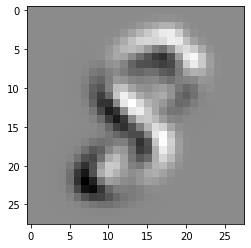

In [208]:
plt.imshow(-np.reshape(p_r_train[0],(28,28)), cmap='gray_r')

<div id="ch:method_1"></div>

**Fonction de classification pour la rotation:**

In [209]:
def estim_R(j): #estime l'image data_test[j]
    A=[np.hstack((np.reshape(-p_r_train[i],(-1,1)),np.reshape(p_r_test[j],(-1,1)))) for i in range(800)]
    b=[np.reshape(smooth_train[i]-smooth_test[j],(-1,1)) for i in range(800)]
    résidus=[np.linalg.lstsq(A[i], b[i], rcond=None)[1][0] for i in range(800)] 
    return label_train[résidus.index(min(résidus))]

<div id="ch:method_1"></div>

**Résultats de précision:**

In [210]:
def precis_R(j):
    digits_j=[i for i in range(200) if label_test[i]==j]
    a=len(digits_j)
    estimations=[estim_R(i) for i in digits_j]
    return list(estimations).count(j)/a

In [212]:
précision_totale=[]
for j in range(10):
    précision_totale+=[precis_R(j)*100]
    print('Précision pour le chiffre', j, 'est :',précision_totale[j], '%' )
print('Précision totale est :',sum(précision_totale)/10, '%' )

Précision pour le chiffre 0 est : 100.0 %
Précision pour le chiffre 1 est : 100.0 %
Précision pour le chiffre 2 est : 88.0 %
Précision pour le chiffre 3 est : 83.33333333333334 %
Précision pour le chiffre 4 est : 94.73684210526315 %
Précision pour le chiffre 5 est : 93.33333333333333 %
Précision pour le chiffre 6 est : 100.0 %
Précision pour le chiffre 7 est : 79.3103448275862 %
Précision pour le chiffre 8 est : 88.88888888888889 %
Précision pour le chiffre 9 est : 76.92307692307693 %
Précision totale est : 90.45258194114818 %


## 3.4 Scaling

In [214]:
p_s_train=tuples_x*np.array(p_x_train)+tuples_y*np.array(p_y_train)
p_s_test=tuples_x*np.array(p_x_test)+tuples_y*np.array(p_y_test)

<div id="ch:method_1"></div>

**Voici p_s pour le chiffre vu précedemment:**

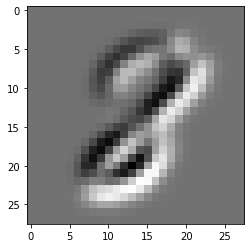

In [262]:
plt.imshow(np.reshape(p_s_train[0],(28,28)), cmap='gray_r')

<div id="ch:method_1"></div>

**Fonction de classification pour le scaling:**

In [215]:
def estim_S(j): #estime l'image data_test[j]
    A=[np.hstack((np.reshape(-p_s_train[i],(-1,1)),np.reshape(p_s_test[j],(-1,1)))) for i in range(800)]
    b=[np.reshape(smooth_train[i]-smooth_test[j],(-1,1)) for i in range(800)]
    résidus=[np.linalg.lstsq(A[i], b[i], rcond=None)[1][0] for i in range(800)] 
    return label_train[résidus.index(min(résidus))]

<div id="ch:method_1"></div>

**Résultats de précision:**

In [216]:
def precis_S(j):
    digits_j=[i for i in range(200) if label_test[i]==j]
    a=len(digits_j)
    estimations=[estim_S(i) for i in digits_j]
    return list(estimations).count(j)/a

In [217]:
précision_totale=[]
for j in range(10):
    précision_totale+=[precis_S(j)*100]
    print('Précision pour le chiffre', j, 'est :',précision_totale[j], '%' )
print('Précision totale est :',sum(précision_totale)/10, '%' )

Précision pour le chiffre 0 est : 100.0 %
Précision pour le chiffre 1 est : 100.0 %
Précision pour le chiffre 2 est : 88.0 %
Précision pour le chiffre 3 est : 83.33333333333334 %
Précision pour le chiffre 4 est : 94.73684210526315 %
Précision pour le chiffre 5 est : 93.33333333333333 %
Précision pour le chiffre 6 est : 100.0 %
Précision pour le chiffre 7 est : 86.20689655172413 %
Précision pour le chiffre 8 est : 94.44444444444444 %
Précision pour le chiffre 9 est : 76.92307692307693 %
Précision totale est : 91.69779266911755 %


## 3.5 Transformation parallèle hyperbolique

In [218]:
p_TPH_train=tuples_x*np.array(p_x_train)-tuples_y*np.array(p_y_train)
p_TPH_test=tuples_x*np.array(p_x_test)-tuples_y*np.array(p_y_test)

<div id="ch:method_1"></div>

**Voici p_TPH pour le chiffre vu précedemment:**

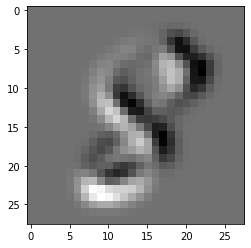

In [219]:
plt.imshow(np.reshape(p_TPH_train[0],(28,28)), cmap='gray_r')

<div id="ch:method_1"></div>

**Fonction de classification pour la transformation parallèle hyperbolique:**

In [227]:
def estim_TPH(j): #estime l'image data_test[j]
    A=[np.hstack((np.reshape(-p_TPH_train[i],(-1,1)),np.reshape(p_TPH_test[j],(-1,1)))) for i in range(800)]
    b=[np.reshape(smooth_train[i]-smooth_test[j],(-1,1)) for i in range(800)]
    résidus=[np.linalg.lstsq(A[i], b[i], rcond=None)[1][0] for i in range(800)] 
    return label_train[résidus.index(min(résidus))]

<div id="ch:method_1"></div>

**Résultats de précision:**

In [228]:
def precis_TPH(j):
    digits_j=[i for i in range(200) if label_test[i]==j]
    a=len(digits_j)
    estimations=[estim_TPH(i) for i in digits_j]
    return list(estimations).count(j)/a

In [230]:
précision_totale=[]
for j in range(10):
    précision_totale+=[precis_TPH(j)*100]
    print('Précision pour le chiffre', j, 'est :',précision_totale[j], '%' )
print('Précision totale est :',sum(précision_totale)/10, '%' )

Précision pour le chiffre 0 est : 100.0 %
Précision pour le chiffre 1 est : 100.0 %
Précision pour le chiffre 2 est : 88.0 %
Précision pour le chiffre 3 est : 83.33333333333334 %
Précision pour le chiffre 4 est : 94.73684210526315 %
Précision pour le chiffre 5 est : 93.33333333333333 %
Précision pour le chiffre 6 est : 100.0 %
Précision pour le chiffre 7 est : 86.20689655172413 %
Précision pour le chiffre 8 est : 88.88888888888889 %
Précision pour le chiffre 9 est : 76.92307692307693 %
Précision totale est : 91.14223711356199 %


## 3.6 Transformation diagonale hyperbolique

In [231]:
p_TDH_train=tuples_y*np.array(p_x_train)+tuples_x*np.array(p_y_train)
p_TDH_test=tuples_y*np.array(p_x_test)+tuples_x*np.array(p_y_test)

<div id="ch:method_1"></div>

**Voici p_TDH pour le chiffre vu précedemment:**

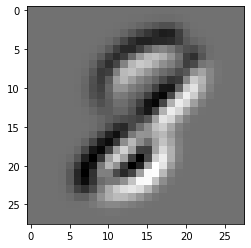

In [232]:
plt.imshow(np.reshape(p_TDH_train[0],(28,28)), cmap='gray_r')

<div id="ch:method_1"></div>

**Fonction de classification pour la transformation diagonale hyperbolique:**

In [233]:
def estim_TDH(j): #estime l'image data_test[j]
    A=[np.hstack((np.reshape(-p_TDH_train[i],(-1,1)),np.reshape(p_TDH_test[j],(-1,1)))) for i in range(800)]
    b=[np.reshape(smooth_train[i]-smooth_test[j],(-1,1)) for i in range(800)]
    résidus=[np.linalg.lstsq(A[i], b[i], rcond=None)[1][0] for i in range(800)] 
    return label_train[résidus.index(min(résidus))]

<div id="ch:method_1"></div>

**Résultats de précision:**

In [234]:
def precis_TDH(j):
    digits_j=[i for i in range(200) if label_test[i]==j]
    a=len(digits_j)
    estimations=[estim_TDH(i) for i in digits_j]
    return list(estimations).count(j)/a

In [235]:
précision_totale=[]
for j in range(10):
    précision_totale+=[precis_TDH(j)*100]
    print('Précision pour le chiffre', j, 'est :',précision_totale[j], '%' )
print('Précision totale est :',sum(précision_totale)/10, '%' )

Précision pour le chiffre 0 est : 100.0 %
Précision pour le chiffre 1 est : 100.0 %
Précision pour le chiffre 2 est : 84.0 %
Précision pour le chiffre 3 est : 83.33333333333334 %
Précision pour le chiffre 4 est : 94.73684210526315 %
Précision pour le chiffre 5 est : 93.33333333333333 %
Précision pour le chiffre 6 est : 100.0 %
Précision pour le chiffre 7 est : 82.75862068965517 %
Précision pour le chiffre 8 est : 88.88888888888889 %
Précision pour le chiffre 9 est : 76.92307692307693 %
Précision totale est : 90.39740952735508 %


## 3.7 Thickening

In [236]:
p_T_train=np.array(p_x_train)**2+np.array(p_y_train)**2
p_T_test=np.array(p_x_test)**2+np.array(p_y_test)**2

<div id="ch:method_1"></div>

**Voici p_T pour le chiffre vu précedemment:**

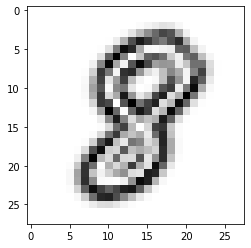

In [237]:
plt.imshow(np.reshape(p_T_train[0],(28,28)), cmap='gray_r')

<div id="ch:method_1"></div>

**Fonction de classification pour le thickening:**

In [238]:
def estim_T(j): #estime l'image data_test[j]
    A=[np.hstack((np.reshape(-p_T_train[i],(-1,1)),np.reshape(p_T_test[j],(-1,1)))) for i in range(800)]
    b=[np.reshape(smooth_train[i]-smooth_test[j],(-1,1)) for i in range(800)]
    résidus=[np.linalg.lstsq(A[i], b[i], rcond=None)[1][0] for i in range(800)] 
    return label_train[résidus.index(min(résidus))]

<div id="ch:method_1"></div>

**Résultats de précision:**

In [239]:
def precis_T(j):
    digits_j=[i for i in range(200) if label_test[i]==j]
    a=len(digits_j)
    estimations=[estim_T(i) for i in digits_j]
    return list(estimations).count(j)/a

In [240]:
précision_totale=[]
for j in range(10):
    précision_totale+=[precis_T(j)*100]
    print('Précision pour le chiffre', j, 'est :',précision_totale[j], '%' )
print('Précision totale est :',sum(précision_totale)/10, '%' )

Précision pour le chiffre 0 est : 100.0 %
Précision pour le chiffre 1 est : 100.0 %
Précision pour le chiffre 2 est : 80.0 %
Précision pour le chiffre 3 est : 83.33333333333334 %
Précision pour le chiffre 4 est : 89.47368421052632 %
Précision pour le chiffre 5 est : 100.0 %
Précision pour le chiffre 6 est : 95.45454545454545 %
Précision pour le chiffre 7 est : 75.86206896551724 %
Précision pour le chiffre 8 est : 88.88888888888889 %
Précision pour le chiffre 9 est : 84.61538461538461 %
Précision totale est : 89.7627905468196 %
